In [21]:
import pandas as pd, numpy as np, warnings, matplotlib.pyplot as plt, seaborn as sns, gc
warnings.filterwarnings('ignore')

In [22]:
path = '../dsets/horse_health'

<Axes: xlabel='outcome', ylabel='count'>

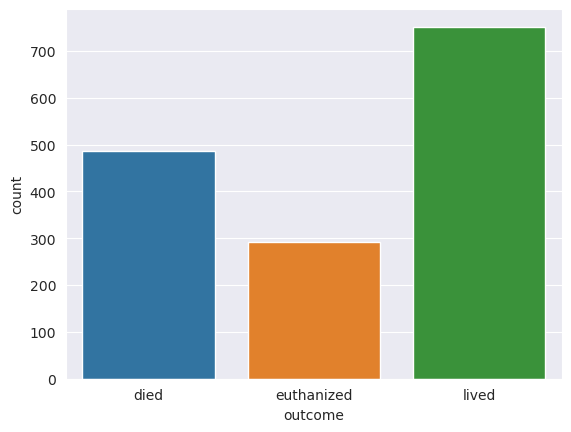

In [23]:
train = pd.read_csv('./data/combined.csv')
test = pd.read_csv(path+'/test.csv', index_col='id')
sns.countplot(train, x='outcome')

In [24]:
surgeryMap = {'yes':0, 'no':1}
mapSurgery = {0:'yes', 1:'no'}
train['surgery'] = train['surgery'].map(surgeryMap)

In [25]:
outcome_map = train.outcome.unique()
outcome_map = {w:i for i,w in enumerate(outcome_map)}
reverse_outcome_map = {outcome_map[k]:k for k in outcome_map.keys()}
train['outcome'] = train['outcome'].map(outcome_map)

In [26]:
def getNumCatCol(df):
    cat_cols = []
    num_cols = []
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            num_cols.append(col)
        else:
            cat_cols.append(col)
    return cat_cols, num_cols

In [27]:
cat_cols, num_cols = getNumCatCol(train)

In [28]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def preprocessing(df, le_cols, ohe_cols):

    le = LabelEncoder()

    for col in le_cols:
        df[col] = le.fit_transform(df[col])

    df = pd.get_dummies(df, columns = ohe_cols)

    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')

    df["temp_of_extremities"] = df["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    df["peripheral_pulse"] = df["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    df["capillary_refill_time"] = df["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    df["pain"] = df["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    df["peristalsis"] = df["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    df["abdominal_distention"] = df["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
    df["nasogastric_tube"] = df["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    df["nasogastric_reflux"] = df["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    df["rectal_exam_feces"] = df["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    df["abdomen"] = df["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    df["abdomo_appearance"] = df["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})

    df.drop('lesion_3',axis=1,inplace=True)

    return df

def features_engineering(df):
    df['lesion_2'] = df['lesion_2'].apply(lambda x:1 if x>0 else 0)
    data_preprocessed = df.copy()

    data_preprocessed["abs_rectal_temp"] = (data_preprocessed["rectal_temp"] - 37.8).abs()
    data_preprocessed.drop(columns=["rectal_temp"])

    return data_preprocessed

In [29]:
le_cols = ["surgery", "age", "surgical_lesion", "cp_data"]
ohe_cols = ["mucous_membrane"]

train = preprocessing(train, le_cols, ohe_cols)
test = preprocessing(test, le_cols, ohe_cols)

In [30]:
train = features_engineering(train)
test = features_engineering(test)

In [31]:
cat_cols, num_cols = getNumCatCol(train)

In [32]:
from sklearn.impute import KNNImputer

knn = KNNImputer(n_neighbors=12)

df_train_knn = pd.DataFrame(knn.fit_transform(train[num_cols]), columns=num_cols)

In [33]:
t_num_cols = train.drop(axis='columns', columns='outcome').columns
df_test_knn = pd.DataFrame(knn.fit_transform(test[t_num_cols]), columns=t_num_cols)

In [34]:
test_2 = test.drop(t_num_cols, axis=1).reset_index()
test_2 = pd.concat([test_2, df_test_knn], axis=1)
test_2.drop(['id'], axis=1, inplace=True)

In [35]:
train_2 = train.drop(num_cols, axis=1).reset_index()
train_2 = pd.concat([train_2, df_train_knn], axis=1)
train_2.drop(['index'], axis=1, inplace=True)

In [36]:
import torch
import torch.nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [37]:
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split

X_t = train_2.drop('outcome', axis=1)
y_t = train_2['outcome']

In [38]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

smot = SMOTE()
rand_u_samp = RandomUnderSampler()
pipe = Pipeline([('overSamp', smot), ('underSamp', rand_u_samp)])

X_t, y_t = pipe.fit_resample(X_t, y_t)

<Axes: xlabel='outcome', ylabel='count'>

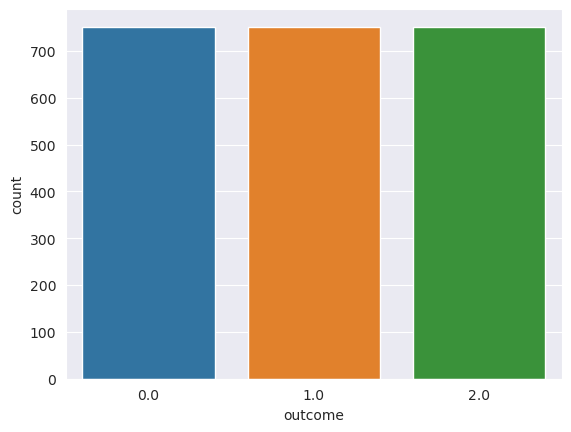

In [39]:
sns.countplot(data=pd.concat([X_t, y_t], axis=1), x='outcome')

In [20]:
X_t, X_v, y_t, y_v = train_test_split(X_t, y_t, train_size=0.9)

In [21]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,HistGradientBoostingClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression

def train(model):
    kf = KFold(n_splits=5, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t)):
        X_train, X_val = X_t.iloc[train_idx], X_t.iloc[val_idx]
        y_train, y_val = y_t.iloc[train_idx], y_t.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        print('FOLD: ', i)
        print('aucarcy score: ', accuracy_score(y_val, y_pred))
        print('='*25)

def test(test_set, model):
    y_pred = model.predict(test_set)
    return y_pred

In [107]:
model1 = XGBClassifier({'learning_rate':0.01, 'objective':'multi:softmax','eval_metric': 'merror', 'tree_method':'gpu_hist', 'predictor':'gpu_predictor'}, device='gpu')
train(model1)
y_val_pred = test(X_v, model1)
print(accuracy_score(y_v, y_val_pred))

FOLD:  0
aucarcy score:  0.8571428571428571
FOLD:  1
aucarcy score:  0.7881773399014779
FOLD:  2
aucarcy score:  0.8078817733990148
FOLD:  3
aucarcy score:  0.7807881773399015
FOLD:  4
aucarcy score:  0.7980295566502463
0.8716814159292036


In [108]:
model2 = DecisionTreeClassifier()
y_val2 = train(model2)
#y_pred2 = test(model2)
y_val_pred = test(X_v, model2)
print(accuracy_score(y_v, y_val_pred))

FOLD:  0
aucarcy score:  0.7216748768472906
FOLD:  1
aucarcy score:  0.6625615763546798
FOLD:  2
aucarcy score:  0.6773399014778325
FOLD:  3
aucarcy score:  0.6650246305418719
FOLD:  4
aucarcy score:  0.7019704433497537
0.668141592920354


In [109]:
model3 = AdaBoostClassifier()
y_val3 = train(model3)
#y_pred3 = test(model3)
y_val_pred = test(X_v, model3)
print(accuracy_score(y_v, y_val_pred))


FOLD:  0
aucarcy score:  0.7413793103448276
FOLD:  1
aucarcy score:  0.7142857142857143
FOLD:  2
aucarcy score:  0.6995073891625616
FOLD:  3
aucarcy score:  0.7389162561576355
FOLD:  4
aucarcy score:  0.7044334975369458
0.7433628318584071


In [40]:
model4 = LogisticRegression(n_jobs=6)

NameError: name 'LogisticRegression' is not defined

In [41]:
total = pd.concat([X_t, y_t], axis=1).reset_index()

In [42]:
total[752:(752*2)]

,index,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,surgery,age,hospital_number,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,abs_rectal_temp,outcome
752,2002,False,False,False,True,False,True,0.000000,0.0,5.347870e+05,...,41.261736,75.000000,1.0,1.000000,0.000000,3111.000000,0.0,0.710289,0.413087,1.0
753,740,False,False,False,False,False,True,0.000000,0.0,5.338710e+05,...,55.000000,65.000000,1.0,1.000000,0.000000,7209.000000,0.0,0.000000,0.200000,1.0
754,2007,False,False,False,False,True,False,0.010574,0.0,5.302420e+05,...,52.000000,8.595770,2.0,7.400000,1.000000,2207.000000,0.0,0.010574,0.600000,1.0
755,1856,False,False,True,False,True,False,0.000000,0.0,5.345560e+05,...,60.258301,81.000000,1.0,2.000000,0.491666,2208.000000,0.0,0.000000,0.547500,1.0
756,957,False,False,False,False,False,True,0.000000,0.0,5.351300e+05,...,48.000000,66.000000,2.0,2.000000,1.000000,2205.000000,0.0,0.000000,0.700000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,328,False,False,False,True,False,False,1.000000,0.0,5.282980e+05,...,45.000000,7.500000,0.0,5.000000,0.000000,8300.000000,0.0,1.000000,0.200000,1.0
1500,2198,False,False,False,True,True,False,0.381870,0.0,5.275212e+06,...,51.236261,47.178467,2.0,3.510028,1.000000,2205.000000,0.0,0.000000,0.556317,1.0
1501,1437,False,True,False,False,False,False,1.000000,0.0,5.281510e+05,...,53.083333,11.075000,2.0,3.325000,0.000000,4124.000000,0.0,0.000000,0.700000,1.0
1502,2130,False,False,False,False,True,True,0.000000,0.0,5.286826e+05,...,47.074955,6.354803,2.0,3.221544,1.000000,2207.290395,0.0,0.763465,0.807496,1.0


In [43]:
def get_target_dist(df, target):
    class_0 = df[target]

In [51]:
class CSVDataset(Dataset):
    def __init__(self, csv_file, test=False):
        self.csv_file = csv_file
        self.rows = csv_file.shape[0]
        self.test = test
        
        # OG
        self.X = None
        self.Y = None
        self.X_valid = None
        self.Y_valid = None
        
        # Tensors
        self.X_tensor = None
        self.Y_tensor = None
        self.X_eval_tensor = None
        self.Y_eval_tensor = None
        
        
    def _split(self, target, train_size=0.9):
        if not self.test:
            
            
            og = 752 
            class_rows = og*0.95
            class_rows = int((class_rows - class_rows%100))
            self.valid_rows = og - class_rows
            
            self.X = self.csv_file[:class_rows] # 700
            self.X_valid = self.csv_file[class_rows:og] #700-752
            
            self.X = pd.concat([self.X, self.csv_file[og:og*2-52]], axis=0) #752-1452
            self.X_valid = pd.concat([self.X_valid, self.csv_file[og*2-52:(og*2)]], axis=0) #1452-1504
            
            self.X = pd.concat([self.X, self.csv_file[(og*2):(og*3-52)]], axis=0) #1504-2104
            self.X_valid = pd.concat([self.X_valid, self.csv_file[(og*3-52):(og*3)]], axis=0)
            
            self.Y = self.csv_file[target][:class_rows]
            self.Y_valid = self.csv_file[target][class_rows:og]
            
            self.Y = pd.concat([self.Y, self.csv_file[target][og:og+class_rows]], axis=0)
            self.Y_valid = pd.concat([self.Y_valid, self.csv_file[target][og+class_rows:(og*2)]], axis=0)
            
            self.Y = pd.concat([self.Y, self.csv_file[target][(og*2):(og*3-52)]], axis=0)
            self.Y_valid = pd.concat([self.Y_valid, self.csv_file[target][(og*3-52):(og*3)]], axis=0)

            self.X.drop([target], axis=1, inplace=True)
            self.X_valid.drop([target], axis=1, inplace=True)

            self.Y = pd.get_dummies(self.Y, columns=[target], drop_first=False, dtype=np.float32)
            self.Y_valid = pd.get_dummies(self.Y_valid, columns=[target], drop_first=False, dtype=np.float32)
            
            print(self.X.columns, self.Y.columns)
        else:
            print('Cannot split test data.')
    
    def toTensor(self):
        if self.test:
            self.X_tensor = torch.tensor(np.array(self.csv_file.values, dtype=np.float32), dtype=torch.float, device='cuda')
            return
        
        with torch.device('cuda'):        
            self.X_tensor = torch.tensor(np.array(self.X.values, dtype=np.float32), dtype=torch.float)
            self.Y_tensor = torch.tensor(np.array(self.Y.values, dtype=np.float32), dtype=torch.float, requires_grad=True)
            self.X_eval_tensor = torch.tensor(np.array(self.X_valid.values, dtype=np.float32), dtype=torch.float)
            self.Y_eval_tensor = torch.tensor(np.array(self.Y_valid.values, dtype=np.float32), dtype=torch.float, requires_grad=True)
        
    def __getitem__(self, item):
        if not self.test:
            return self.X_tensor[item], self.Y_tensor[item]
        return self.X_tensor[item]
    
    def __len__(self):
        return self.X_tensor.size()[0]

In [52]:
import torch.nn as nn

class NNModel(nn.Module):
    def __init__(self, inp_size, out_size, hidden):
        super(NNModel, self).__init__()
        
        self.input_layer = nn.Linear(in_features=inp_size, out_features=hidden)
        self.act1 = nn.LeakyReLU()
        self.hidden_layer = nn.Linear(in_features=hidden, out_features=hidden)
        self.act3 = nn.LeakyReLU()
        self.hidden_layer2 = nn.Linear(in_features=hidden, out_features=hidden)
        self.act2 = nn.LeakyReLU()
        self.output_layer = nn.Linear(in_features=hidden, out_features=out_size)
    
    def forward(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.act1(x)
        x = self.hidden_layer(x)
        x = self.act2(x)
        x = self.hidden_layer2(x)
        x = self.act3(x)
        x = self.output_layer(x)
        return x 

In [53]:
trainSet = CSVDataset(pd.concat([X_t, y_t], axis=1))
trainSet._split('outcome')
trainSet.toTensor()

testSet = CSVDataset(test_2, test=True)
testSet.toTensor()

Index(['mucous_membrane_bright_pink', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink', 'surgery',
       'age', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time',
       'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube',
       'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces',
       'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'cp_data',
       'abs_rectal_temp'],
      dtype='object') Index([0.0, 1.0, 2.0], dtype='float64')


In [54]:
def trainning(dataLoader, epochs, optimizer, criterion, debug = False):
    loss_h = []
    size = len(dataLoader.dataset)
    softmax = nn.Softmax()
    model.train()
    for i in range(epochs):
        for batch, (X, y) in enumerate(dataLoader):
            # Compute predict and loss
            y_hat = model(X)
            # debug
            if debug:
                print(y_hat[0], y[0])
            loss = criterion(y_hat, y)
            # Back prop
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if i%100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"iteration: {i}, loss: {loss}  [{current:>5d}/{size}]")

In [55]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = 104 
    num_batches = 1
    test_loss, correct = 0, 0
    softmax = nn.Softmax()
    
    X_eval = trainSet.X_eval_tensor
    Y_eval = trainSet.Y_eval_tensor
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i in range(size):
            X, y = X_eval[i], Y_eval[i]
            pred = model(X)
            sft = softmax(pred)
            print(sft.argmax(), y.argmax())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {correct:>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [56]:
model = NNModel(train_2.shape[1]-1, 3, 512).to('cuda')
optim = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [57]:
train_loader = DataLoader(trainSet, batch_size=1024, shuffle=True)
test_loader = DataLoader(testSet, batch_size=1, shuffle=True)

In [58]:
trainning(train_loader, 5000, optim, criterion)

iteration: 0, loss: 5306.5166015625  [ 1024/2100]
iteration: 0, loss: 292445.8125  [ 2048/2100]
iteration: 0, loss: 3412811.25  [  156/2100]
iteration: 100, loss: 41.589080810546875  [ 1024/2100]
iteration: 100, loss: 95.83827209472656  [ 2048/2100]
iteration: 100, loss: 30.040687561035156  [  156/2100]
iteration: 200, loss: 18.161121368408203  [ 1024/2100]
iteration: 200, loss: 27.941051483154297  [ 2048/2100]
iteration: 200, loss: 19.277944564819336  [  156/2100]
iteration: 300, loss: 9.334606170654297  [ 1024/2100]
iteration: 300, loss: 10.24014663696289  [ 2048/2100]
iteration: 300, loss: 29.033205032348633  [  156/2100]
iteration: 400, loss: 11.14191722869873  [ 1024/2100]
iteration: 400, loss: 11.664552688598633  [ 2048/2100]
iteration: 400, loss: 19.60796546936035  [  156/2100]
iteration: 500, loss: 12.098081588745117  [ 1024/2100]
iteration: 500, loss: 14.628744125366211  [ 2048/2100]
iteration: 500, loss: 10.903515815734863  [  156/2100]
iteration: 600, loss: 14.50246238708496

In [59]:
test_loop(train_loader, model, criterion)

tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') t